In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Leitura do CSV
df = pd.read_csv('credit_card_fraud_detection.csv', sep=',')

# Verifica se as colunas necessárias existem
colunas_necessarias = ['User ID', 'Country', 'Transaction Amount', 'Fraudulent']
if not all(col in df.columns for col in colunas_necessarias):
    raise ValueError(f"O arquivo precisa conter as colunas: {colunas_necessarias}")

# Criação dos grafos separados por país
country_graphs = {}

# Criando grafo com ID apenas de usuários fraudulentos
client = []
amount = []
for transacao in range(len(df)):
    if df.iloc[transacao]['Fraudulent'] == 'Yes':
        client += [df.iloc[transacao]['User ID']]
        amount += [df.iloc[transacao]['Transaction Amount']]

for country in df['Country'].unique():
    G = nx.Graph()
    df_country = df[df['Country'] == country]

    for _, row in df_country.iterrows():

        G.add_node(client, tipo='cliente')
        G.add_node(country, tipo='pais')
        G.add_edge(client, country, weight=amount)

    country_graphs[country] = G

# Função para plotar os grafos
def plot_graph(G, country):
    pos = nx.spring_layout(G, seed=42)
    clientes = [node for node, attr in G.nodes(data=True) if attr['tipo'] == 'cliente']

    nx.draw_networkx_nodes(G, pos, nodelist=clientes, node_color='blue', node_size=100)
    nx.draw_networkx_nodes(G, pos, nodelist=[country], node_color='red', node_size=200)
    nx.draw_networkx_edges(G, pos, width=1)

    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"Grafo - {country}")
    plt.axis('off')
    plt.show()

# Plota cada grafo
for country, G in country_graphs.items():
    plot_graph(G, country)

TypeError: unhashable type: 'list'


Grau dos vértices dos países (UK e Germany):
Germany: 5
UK: 6


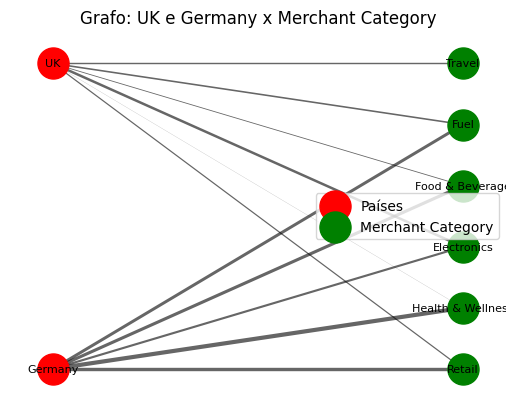

In [11]:
# Agora, utilizando apenas UK e Germany, vamos criar um novo grafo
# conectando 'Country' e 'Merchant Category'

# Define os países de interesse
selected_countries = ["UK", "Germany"]

# Filtra o DataFrame de transações fraudulentas para manter apenas os países selecionados
df_fraud_selected = df_fraud[df_fraud['Country'].isin(selected_countries)]

def create_graph_country_category(dataframe):
    """
    Cria um grafo bipartido conectando 'Country' e 'Merchant Category'
    com arestas ponderadas pelo 'Transaction Amount'.
    """
    G = nx.Graph()
    for _, row in dataframe.iterrows():
        country = row['Country']
        merchant_category = row['Merchant Category']
        amount = row['Transaction Amount']

        # Adiciona os nós com atributo para diferenciar
        G.add_node(country, tipo='pais')
        G.add_node(merchant_category, tipo='merchant_category')

        # Adiciona a aresta com o peso
        G.add_edge(country, merchant_category, weight=amount)
    return G

# Cria o grafo com apenas os países selecionados
G_country_category_selected = create_graph_country_category(df_fraud_selected)

# Calcula o grau dos vértices dos países no novo grafo
degree_country_category_selected = {
    node: G_country_category_selected.degree(node)
    for node, attr in G_country_category_selected.nodes(data=True)
    if attr.get('tipo') == 'pais'
}

print("\nGrau dos vértices dos países (UK e Germany):")
for country, degree in degree_country_category_selected.items():
    print(f"{country}: {degree}")

def plot_graph_country_category(G, title):
    """
    Plota o grafo bipartido com vértices 'Country' e 'Merchant Category',
    normalizando as larguras das arestas para evitar linhas muito grossas.
    """
    # Separa os nós por tipo
    countries = [node for node, attr in G.nodes(data=True) if attr.get('tipo') == 'pais']
    merchant_categories = [node for node, attr in G.nodes(data=True) if attr.get('tipo') == 'merchant_category']

    # Usa layout bipartido para organizar os conjuntos
    pos = nx.bipartite_layout(G, countries)

    # Desenha os nós de países (vermelho) e Merchant Categories (verde)
    nx.draw_networkx_nodes(G, pos, nodelist=countries, node_color='red', label='Países', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=merchant_categories, node_color='green', label='Merchant Category', node_size=500)

    # Coleta as arestas e seus atributos
    edges = list(G.edges(data=True))

    if edges:
        # Extrai todos os pesos
        weights = [edata['weight'] for (_, _, edata) in edges]

        # Garante que não estamos dividindo por zero caso todos os pesos sejam iguais
        min_w, max_w = min(weights), max(weights)

        if min_w == max_w:
            # Se todos os valores forem iguais, define uma largura fixa
            edge_widths = [1.0] * len(edges)
        else:
            # Define intervalo de espessura desejado
            min_width, max_width = 0.1, 3.0
            # Normaliza cada peso para o intervalo [min_width, max_width]
            edge_widths = [
                min_width + (w - min_w) * (max_width - min_width) / (max_w - min_w)
                for w in weights
            ]
    else:
        edge_widths = []

    # Desenha as arestas com as larguras normalizadas
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.6)

    # Desenha rótulos dos nós
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title)
    plt.legend(scatterpoints=1)
    plt.axis('off')
    plt.show()

# Plota o grafo com apenas os países UK e Germany e suas respectivas Merchant Categories
plot_graph_country_category(G_country_category_selected, "Grafo: UK e Germany x Merchant Category")